In [67]:
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import load_digits


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score

In [68]:
# Load the sklearn digits dataset
# data -> X
# target -> y
digits = load_digits()
X = digits.data
y = digits.target

# check the shape of X and y
print(X.shape, y.shape)

(1797, 64) (1797,)


0


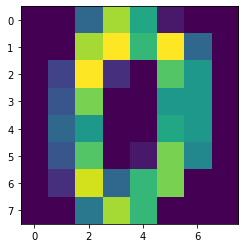

1


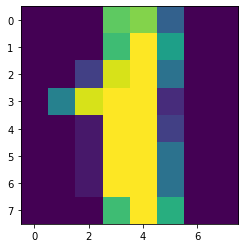

2


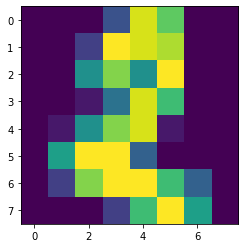

3


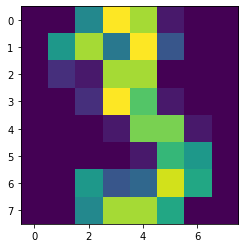

4


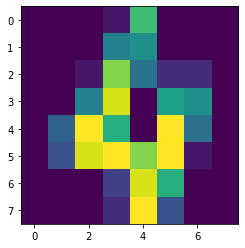

In [69]:
# Visualize the first n digits
for i in range(5):
  image = np.reshape(X[i], (8,8))
  plt.imshow(image)
  print(y[i])
  plt.show()

In [70]:
# Shuffle the dataset
c = list(zip(X, y))
random.shuffle(c)
X,y = zip(*c)
X = np.array(X)
y = np.array(y)

In [71]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Create a list of classifiers:
# a Decision Tree classifier
# a KNN classifier (n_neighbors = 50)
# a Logastic Regression classifier (max_iter = 5000)
model1 = DecisionTreeClassifier(random_state=0)

# Fit all of them to the train set
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)

# Save their prediction on the test set
acc1 = accuracy_score(pred1, y_test)
print(acc1)


0.8416666666666667


In [73]:
model2 = KNeighborsClassifier(n_neighbors=50)
model2.fit(X_train, y_train)
pred2 = model2.predict(X_test)
acc2 = accuracy_score(pred2, y_test)
print(acc2)


0.9583333333333334


In [74]:
model3 = LogisticRegression(random_state=0, max_iter=5000)
model3.fit(X_train, y_train)
pred3 = model3.predict(X_test)
acc3 = accuracy_score(pred3, y_test)
print(acc3)

0.9555555555555556


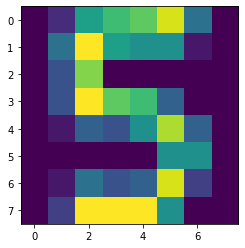

5
5
5


In [75]:
X_test[0]
image = np.reshape(X_test[0], (8,8))
plt.imshow(image)
plt.show()
print(pred1[0])
print(pred2[0])
print(pred3[0])

In [76]:
# Calculate the average of the predictions
# Validate the average on the test set
average_predictions = []
for i in range(len(pred1)):
  average_predictions.append(int((pred1[i] + pred2[i] + pred3[i])/3))

print(accuracy_score(y_test, average_predictions))

0.8333333333333334


In [77]:
# Calculate the weighted average of the predictions
# Validate the average on the test set
average_predictions_weighted = []
for i in range(len(pred1)):
  average_predictions_weighted.append(int(pred1[i]*0.2 + pred2[i]*0.4 + pred3[i]*0.4))

print(accuracy_score(y_test, average_predictions_weighted))

0.8472222222222222


In [78]:
def most_frequent(a):
    return np.argmax(np.bincount(a))

# Calculate the best voted value of the predictions
# Validate the best voted value on the test set
voted_average_prediction = []
for i in range(len(pred1)):
  voted_average_prediction.append(most_frequent([pred1[i], pred2[i], pred3[i]]))

print(accuracy_score(y_test, voted_average_prediction))

0.9611111111111111


In [79]:
# Train the same voting classifier using the sklearn VotingClassifier


# Stacking

![title](stacking.png)

In [80]:
# Create a helper function to create stacking models
# with parameters: model, X, y
def Stacking(model,X,y):
    # split the Train dataset again
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=2)
    # fit the model on the NEW train dataset
    model.fit(X_train2, y_train2)
    # print the accuracy of the model on the NEW test dataset
    print(model.score(X_test2, y_test2))
    # return the model prediction of whole X dataset
    return model.predict(X)


In [81]:
# creaate a decision tree classifier 
model1 = DecisionTreeClassifier(random_state=0)
train_pred1 = Stacking(model1, X_train, y_train)
# Use the Stacking function with the decision tree classifier
# save the results to a variable

0.8854166666666666


In [82]:
# creaate a decision KNN classifier (n_neighbors = 100)) 
model2 = KNeighborsClassifier(n_neighbors=100)
train_pred2 = Stacking(model2, X_train, y_train)
# Use the Stacking function with the decision tree classifier
# save the results to a variable

0.90625


In [83]:
# Train a linear regression meta classifier
train_Middle = np.stack([train_pred1, train_pred2], axis=1)
# stack the predictions of the two classifiers
metamodel = LogisticRegression()
# create a logistic regression classifier
# fit the meta model on the stacked predictions
metamodel.fit(train_Middle, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [84]:
# Create a helper function to evaluate stacking models
# with parameters: X,  models (list of first level models), meta_model
def StackPredict(X, models, meta_model):
    # Collect the predictions of each model of X
    predictions = []
    for model in models:
      predictions.append(model.predict(X))
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, len(models))

    # return the meta model prediction of the stacked predictions
    return meta_model.predict(predictions)

In [85]:
# Calculate the prediction of meta model of X_test
models = [model1, model2]
metaprediction = StackPredict(X_test, models, metamodel)
# Calculate the accuracy of the meta model
print(metaprediction)

[6 4 6 1 4 7 6 4 1 7 1 4 9 4 1 5 4 4 1 5 4 9 1 7 2 6 7 2 1 5 1 8 4 5 5 9 4
 3 3 1 1 9 7 5 1 4 5 8 6 7 9 8 5 1 9 6 1 4 9 3 7 3 8 2 9 3 5 3 1 9 7 9 6 3
 3 2 9 9 9 9 1 3 4 4 3 3 6 1 9 8 1 4 4 6 6 1 2 7 6 4 3 4 0 4 9 3 7 4 8 4 6
 6 5 8 5 4 4 2 0 8 8 6 1 5 8 1 1 4 1 5 3 1 3 7 4 6 3 3 1 8 8 2 8 8 4 1 2 2
 9 4 3 2 7 4 5 9 5 4 6 9 4 4 3 3 1 3 3 4 0 4 4 3 2 7 5 9 3 1 4 6 4 4 6 1 4
 6 6 4 1 7 1 7 9 4 1 5 4 4 1 3 7 5 1 7 2 6 7 8 1 5 1 8 6 7 5 9 4 3 3 1 1 9
 7 7 1 4 5 8 6 7 9 0 4 1 9 4 1 4 9 3 7 3 8 4 9 3 8 6 1 9 7 9 6 3 3 6 9 9 5
 0 1 3 3 4 9 3 6 1 5 8 1 7 7 7 6 1 1 4 6 4 3 4 0 4 6 5 4 4 8 4 6 6 5 8 5 9
 4 3 0 1 0 6 1 5 9 1 1 4 1 5 2 1 3 7 4 6 3 2 1 8 8 2 8 8 4 1 3 2 6 4 3 2 7
 4 4 9 5 4 6 9 4 4 4 8 9 3 3 4 0 4 4 3 4 7 5 4 3 1 4 6]


In [86]:
sum = 0
for i in range(len(y_test)):
  if y_test[i] == metaprediction[i]:
    sum +=1

print(sum/len(y_test))

0.1111111111111111
